In [56]:
import os
import glob

import numpy as np
import matplotlib.pyplot as     plt
from   matplotlib.colors import LogNorm

import invisible_cities.reco    .pmaps_functions as     pmpf
import invisible_cities.database.load_db         as     db
import invisible_cities.core    .fit_functions   as     fitf
from   invisible_cities.reco    .xy_algorithms   import barycenter
from   invisible_cities.core    .ic_types        import xy
from   invisible_cities.reco    .event_model     import Cluster
from   invisible_cities.core    .ic_types        import xy

from   invisible_cities.icaro   .hst_functions   import hist
from   invisible_cities.icaro   .hst_functions   import hist2d
from   invisible_cities.icaro   .hst_functions   import labels

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"]      = 15

In [3]:
filenames     = glob.glob("/Users/Gonzalo/github/NEXTdata/Kr/4446/pmaps.h5")
run_number    = 4446
oneS12filter  = True
zfilter       = True
lfilter       = True
zmin, zmax    =    0, 400
lmin, lmax    =    0, 100

n_noise_cuts  = 10
noise_cuts    = np.linspace(0, 5, n_noise_cuts)

n_sum_cuts    = 4
sum_cuts      = np.linspace(0, 20, n_sum_cuts)

Total    # events = 1700
Selected # events = 799


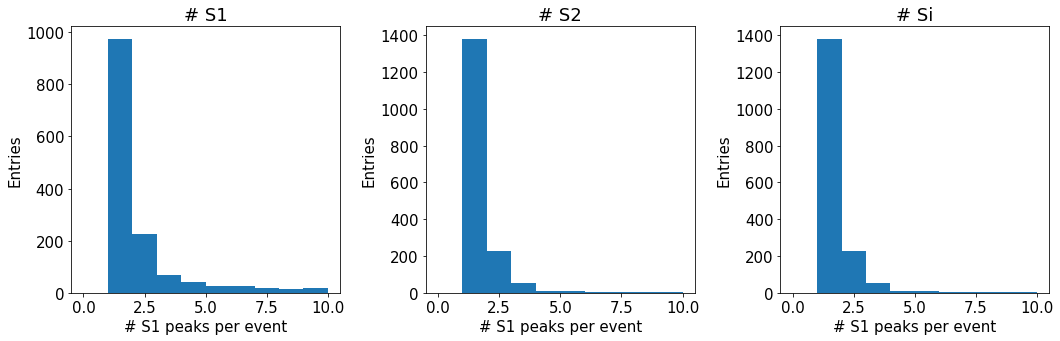

In [4]:
s1ds, s2ds, sids = zip(*map(pmpf.load_pmaps, filenames[:5]))
s1s_, s2s_, sis_ = {}, {}, {}
list(map(s1s_.update, s1ds))
list(map(s2s_.update, s2ds))
list(map(sis_.update, sids))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.hist(list(map(len, s1s_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# S1")
plt.subplot(1,3,2);plt.hist(list(map(len, s2s_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# S2")
plt.subplot(1,3,3);plt.hist(list(map(len, sis_.values())), np.arange(11));labels("# S1 peaks per event", "Entries" , "# Si")
plt.tight_layout()

evt_nos = set(s1s_.keys()) | set(s2s_.keys()) | set(sis_.keys())
print("Total    # events =", len(evt_nos))

# Get those events with exactly 1 S1 and 1 S2 (both in PMTs and SiPMs)
evt_nos = set(s1s_.keys()) & set(s2s_.keys()) & set(sis_.keys())

if oneS12filter:
    evt_nos = list(filter(lambda evt: len(s2s_[evt]) == len(sis_[evt]) == 1  , evt_nos))
if zfilter:
    evt_nos = list(filter(lambda evt: zmin <= (s2s_[evt][0].t[0] -
                                               s1s_[evt][0].t[0])/1000 < zmax, evt_nos))
if lfilter:
    evt_nos = list(filter(lambda evt: lmin <= len(s2s_[evt][0].t) < lmax     , evt_nos))

nevt = len(evt_nos)
print("Selected # events =", len(evt_nos))

s1s = {k:v for k,v in s1s_.items() if k in evt_nos}
s2s = {k:v for k,v in s2s_.items() if k in evt_nos}
sis = {k:v for k,v in sis_.items() if k in evt_nos}

datasipm = db.DataSiPM(run_number)

In [51]:
def sum_evt_ene(s2):
    E = 0
    for peak in s2.values():
        E += peak.E.sum()
    return E

def explore_evt_si(si, thr_noise=1, thr_sum=8):
    assert len(si)==1
    for peak in si.values():
        integrated = {sipm:np.sum(q[q>thr_noise]) for sipm, q in peak.items()\
                      if np.any(q>thr_noise) and np.sum(q[q>thr_noise]) > thr_sum}
        if not integrated:
            return Cluster(0., xy(200,200), xy(200,200), 0)
        sipms, qsipm = list(map(list, zip(*integrated.items())))
        xsipm = datasipm.X.values[sipms]
        ysipm = datasipm.Y.values[sipms]
        nsipm = len(sipms)

        possipm = list(zip(xsipm, ysipm))
        cluster = barycenter(possipm, qsipm)[0]
    return cluster

def check_baricenter(si, thr_noise, thr_sum, nsimax=9):
    assert len(si)==1
    for peak in si.values():
        integrated = {sipm:np.sum(q[q>thr_noise]) for sipm, q in peak.items()\
                      if np.any(q>thr_noise) and np.sum(q[q>thr_noise]) > thr_sum}
        if not integrated:
            return [0]*9
        sipms, qsipm = list(map(list, zip(*integrated.items())))
        qsipm, sipms = list(zip(*sorted(zip(qsipm, sipms))[::-1]))
        xsipm = datasipm.X.values[list(sipms)]
        ysipm = datasipm.Y.values[list(sipms)]
        nsipm = len(sipms)
        possipm = list(zip(xsipm, ysipm))

        drs      = []
        cluster0 = barycenter(possipm, qsipm)[0]
        for nsi in range(1,nsimax+1):
            cluster = barycenter(possipm[:nsi], qsipm[:nsi])[0]
            dr = ((cluster.X - cluster0.X)**2 +
                  (cluster.Y - cluster0.Y)**2)**0.5
            drs.append(dr)
    return drs
    
def get(var, array):
    return np.array(list(map(lambda x: getattr(x, var), array)))

def npmap(*args, **kwargs):
    return np.array(list(map(*args, **kwargs)))

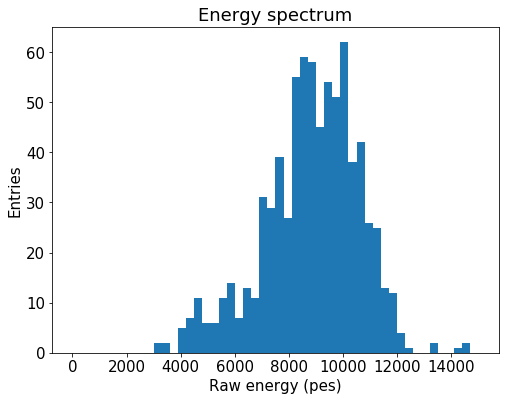

In [19]:
hist(list(map(sum_evt_ene, s2s.values())), 50, (0, 15e3))
labels("Raw energy (pes)", "Entries", "Energy spectrum")

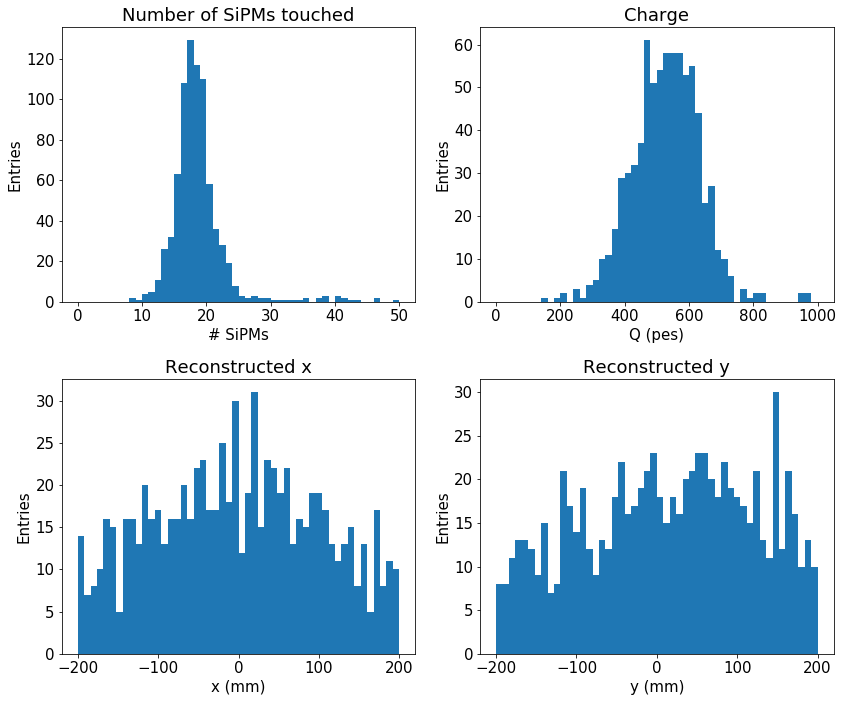

In [20]:
sidata = list(map(explore_evt_si, sis.values()))
plt.figure(figsize=(12,10))
plt.subplot(2,2,1);hist(get("nsipm", sidata), 50, (   0,   50), new_figure=False);labels("# SiPMs", "Entries", "Number of SiPMs touched")
plt.subplot(2,2,2);hist(get("Q"    , sidata), 50, (   0, 10e2), new_figure=False);labels("Q (pes)", "Entries", "Charge")
plt.subplot(2,2,3);hist(get("X"    , sidata), 50, (-200,  200), new_figure=False);labels("x (mm)" , "Entries", "Reconstructed x")
plt.subplot(2,2,4);hist(get("Y"    , sidata), 50, (-200,  200), new_figure=False);labels("y (mm)" , "Entries", "Reconstructed y")
plt.tight_layout()

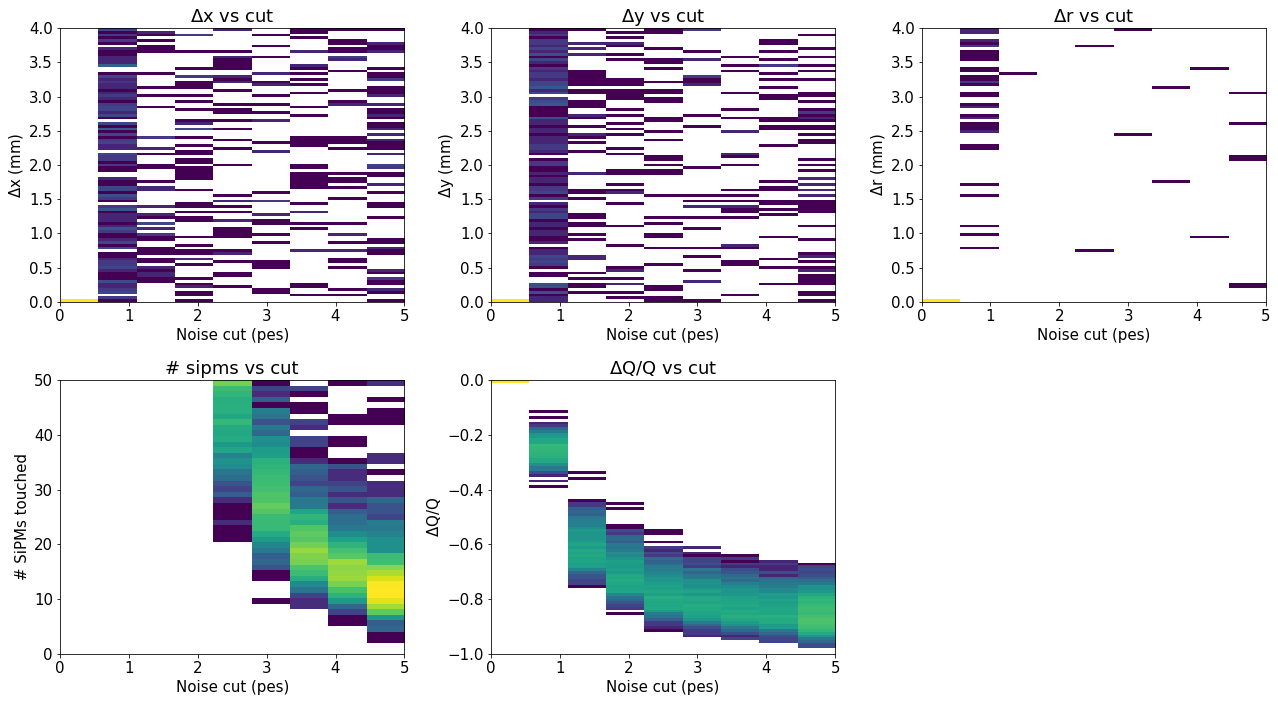

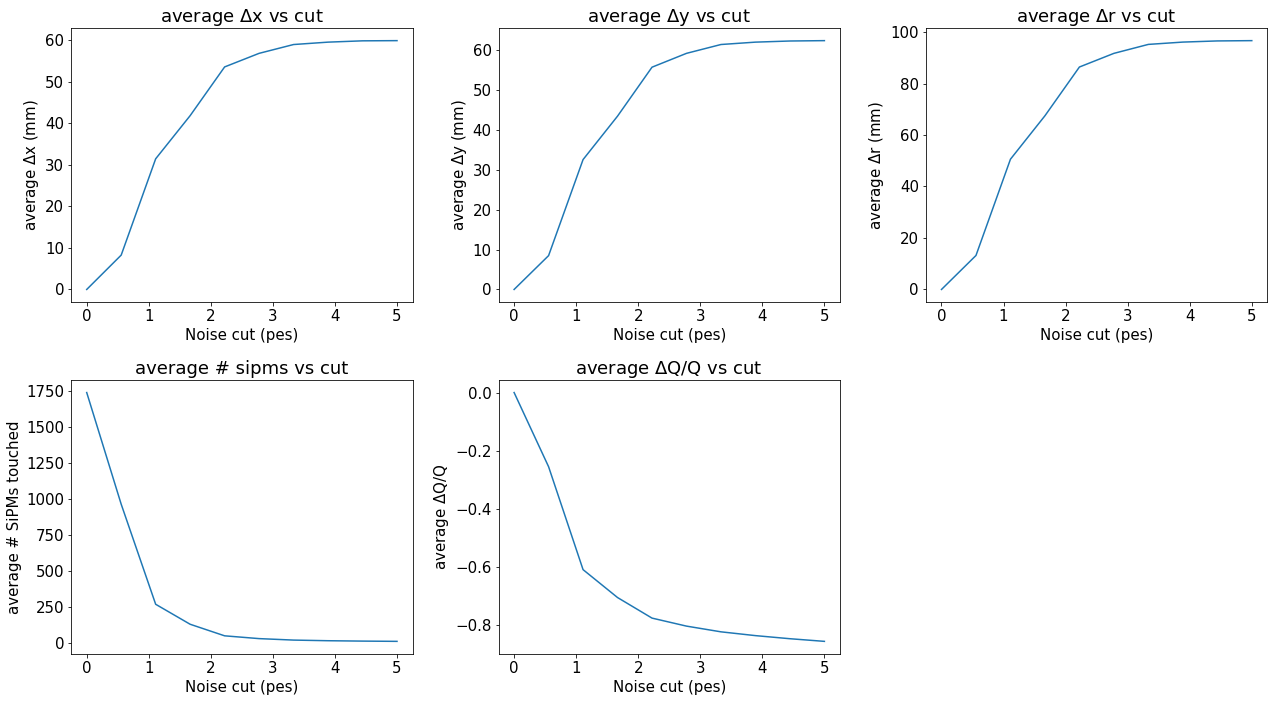

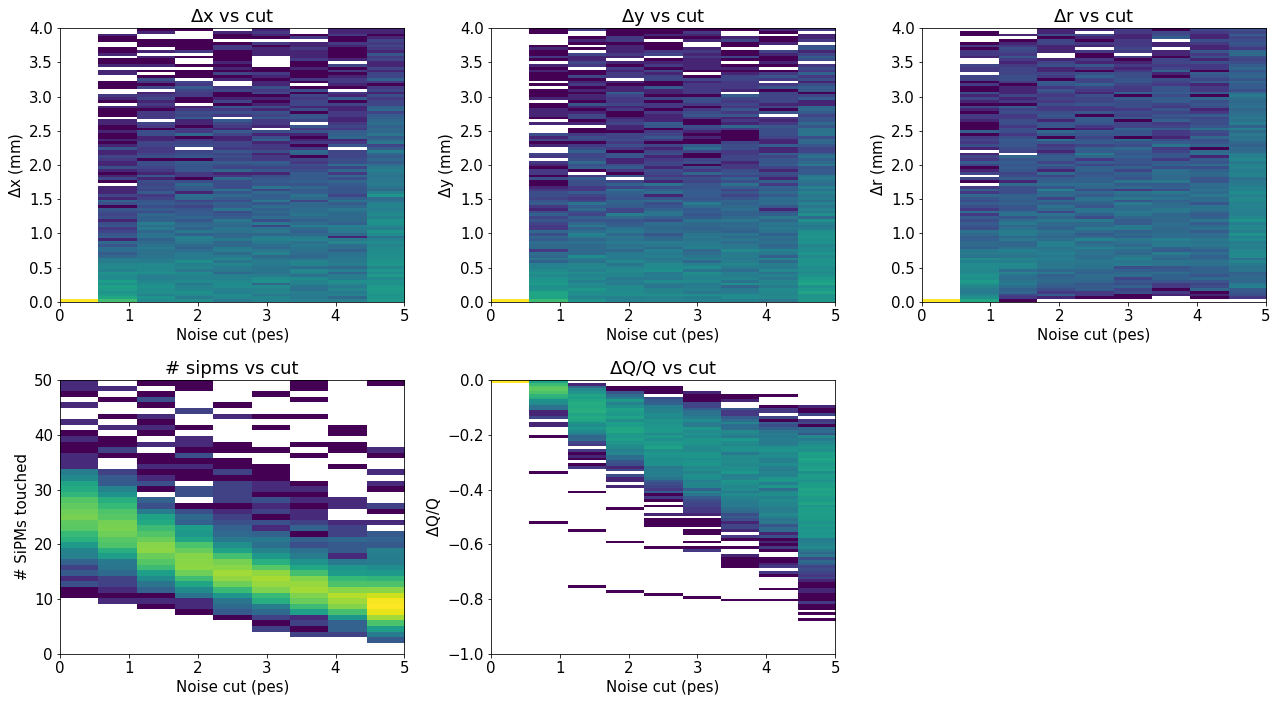

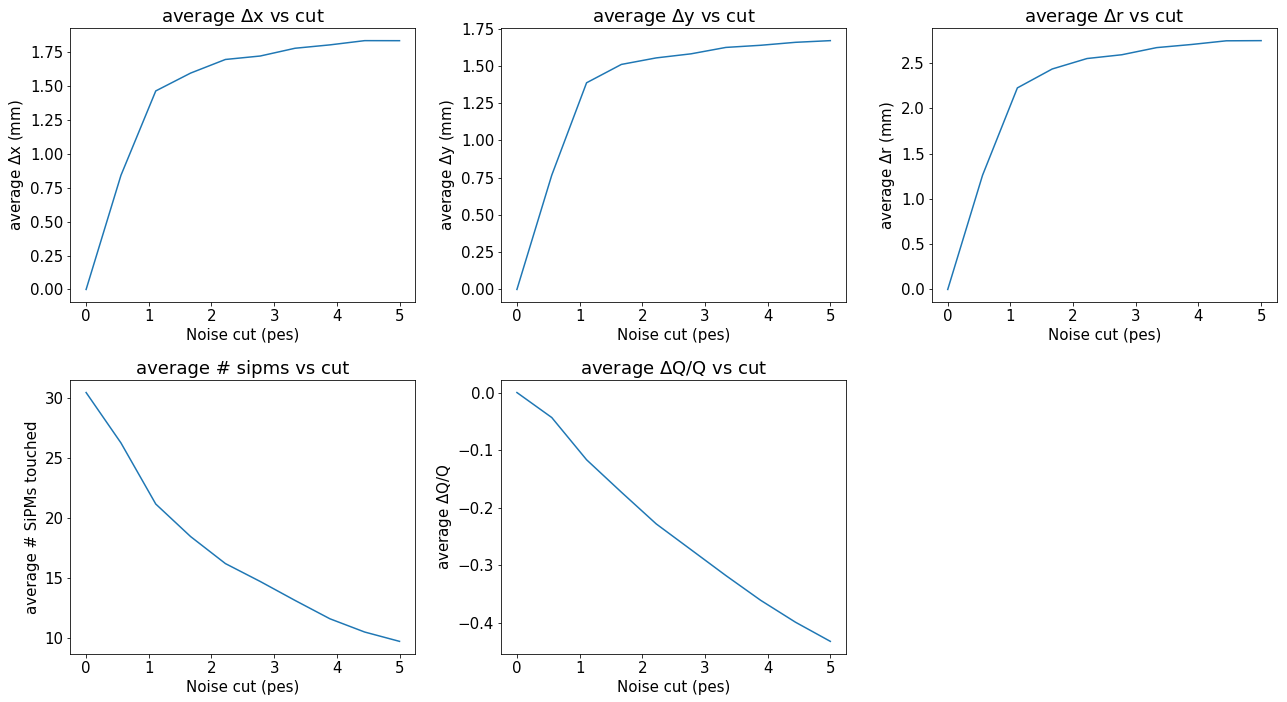

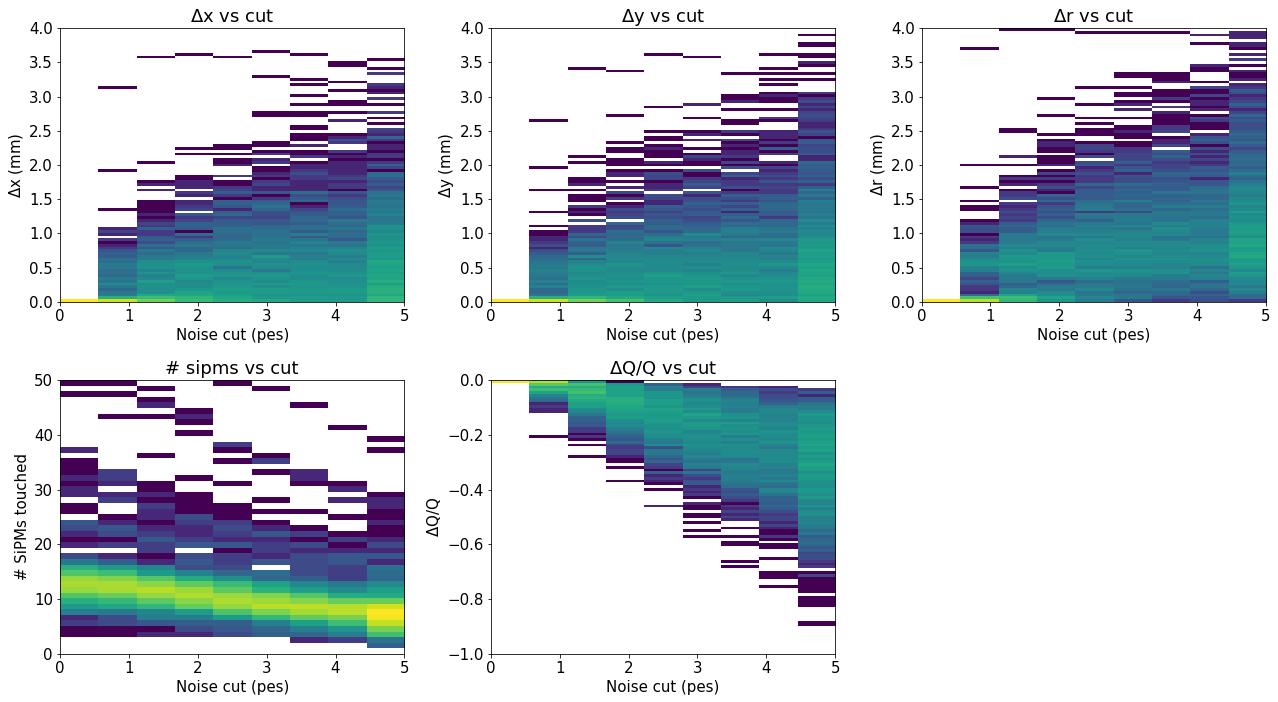

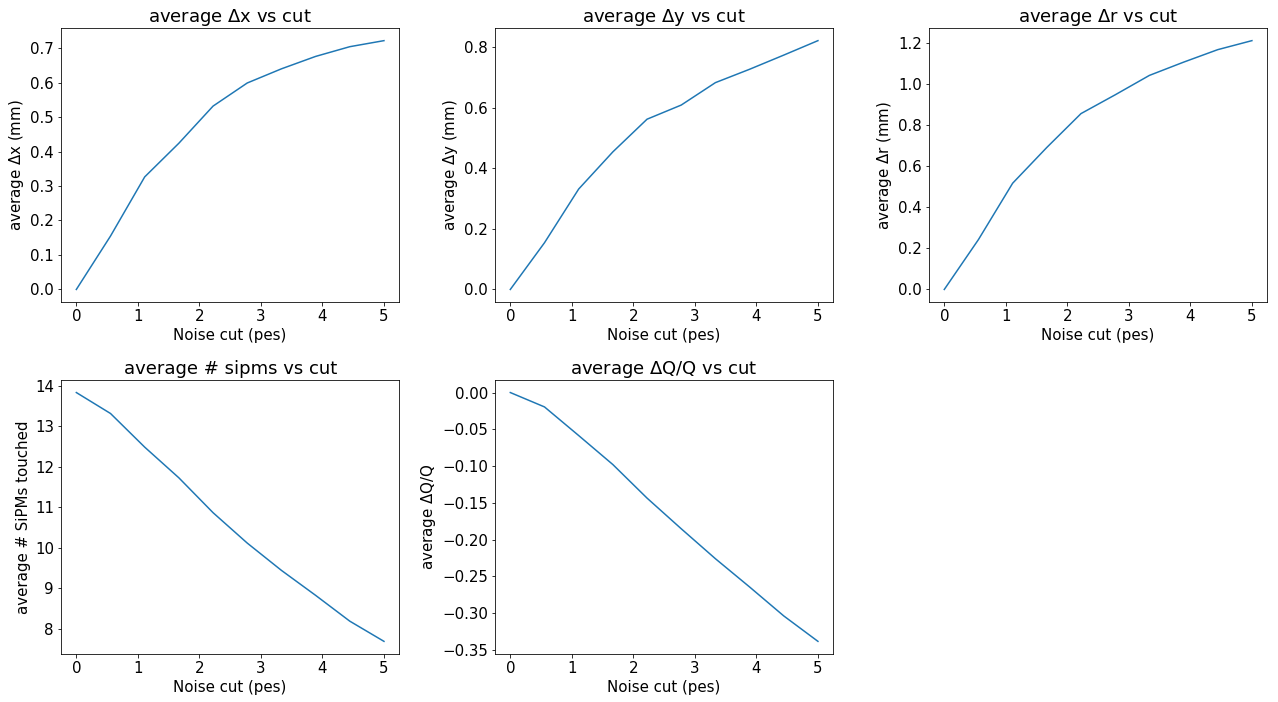

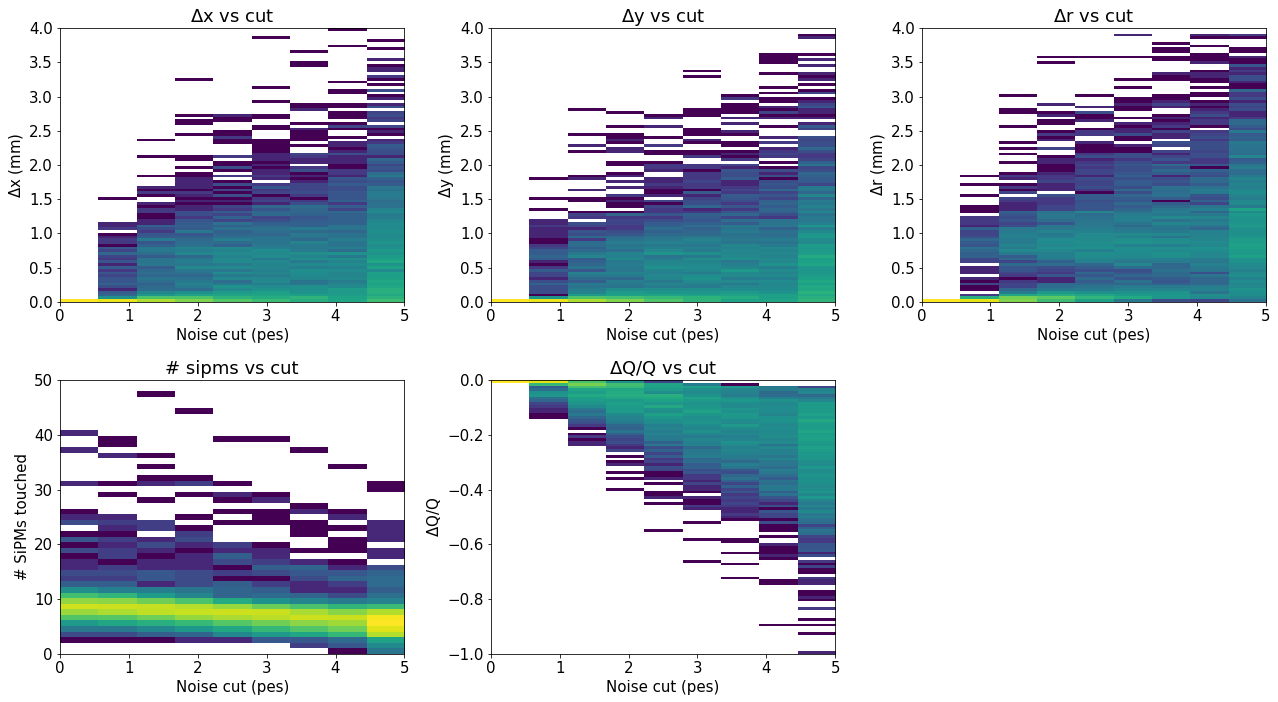

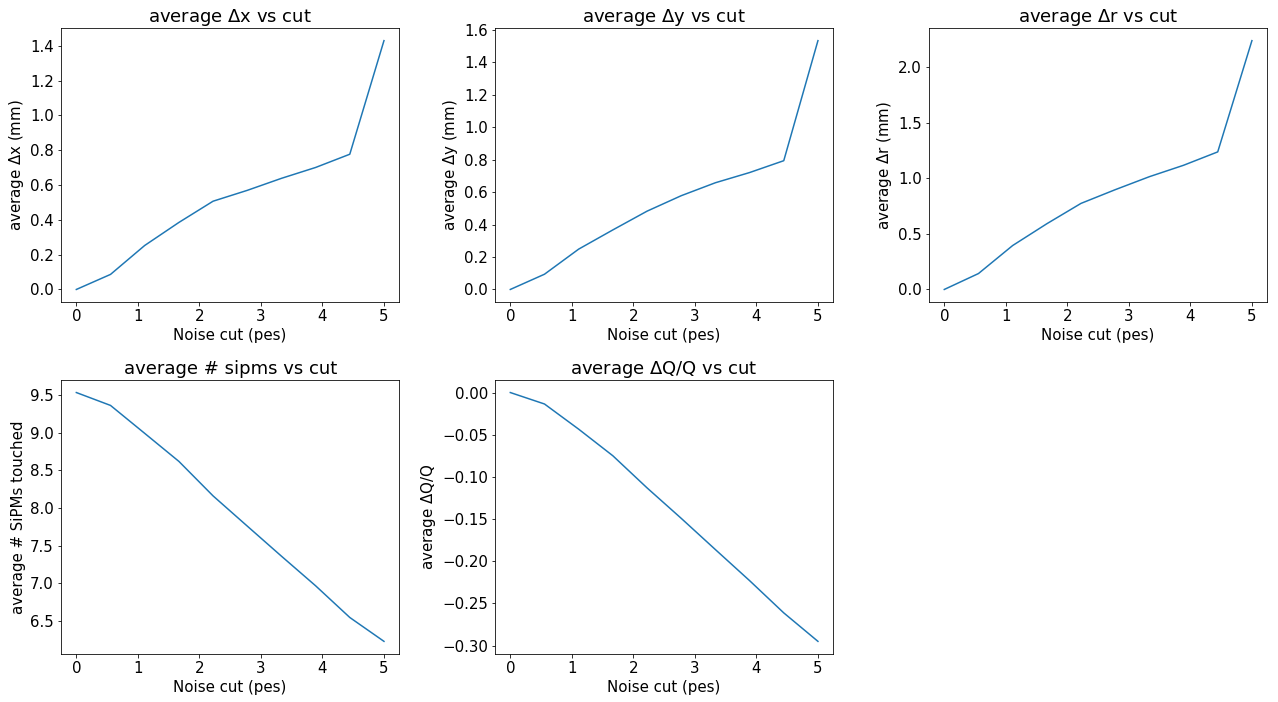

In [21]:
for sum_cut in sum_cuts:
    min_cut = list(map(lambda x: explore_evt_si(x, 0.0, sum_cut), sis.values()))
    qref    = get("Q", min_cut)
    xref    = get("X", min_cut)
    yref    = get("Y", min_cut)

    nsipms = np.zeros((n_noise_cuts, nevt))
    dx     = np.zeros_like(nsipms)
    dy     = np.zeros_like(nsipms)
    qratio = np.zeros_like(nsipms)

    x      = np.zeros_like(nsipms)
    y      = np.zeros_like(nsipms)
    q      = np.zeros_like(nsipms)

    dx      = np.zeros_like(nsipms)
    dy      = np.zeros_like(nsipms)
    dq      = np.zeros_like(nsipms)

    for i, noise_cut in enumerate(noise_cuts):
        sidata = list(map(lambda x: explore_evt_si(x, noise_cut, sum_cut), sis.values()))
        nsipms[i, :] = get("nsipm", sidata)
        x     [i, :] = get("X"    , sidata)
        y     [i, :] = get("Y"    , sidata)
        q     [i, :] = get("Q"    , sidata)

        dx    [i, :] = np.abs(x[i, :] - xref)
        dy    [i, :] = np.abs(y[i, :] - yref)
        dq    [i, :] =        q[i, :] / qref - 1


    _noise_cuts = np.repeat(noise_cuts, nevt)

    dr     = (dx**2 + dy**2)**0.5
    r      = ( x**2 +  y**2)**0.5

    dx_binning = noise_cuts, np.linspace( 0, 4 , 100)
    dy_binning = noise_cuts, np.linspace( 0, 4 , 100)
    dr_binning = noise_cuts, np.linspace( 0, 4 , 100)
    ns_binning = noise_cuts, np.linspace( 0, 50,  50)
    dq_binning = noise_cuts, np.linspace(-1,  0, 100)

    #nsipms[nsipms > 500] = 10 

    plt.figure(figsize=(18,10))
    plt.subplot(2,3,1);hist2d(_noise_cuts, dx    .flatten(), dx_binning, norm=LogNorm(), new_figure=False);labels("Noise cut (pes)", "$\Delta$x (mm)" , "$\Delta$x vs cut"  )
    plt.subplot(2,3,2);hist2d(_noise_cuts, dy    .flatten(), dy_binning, norm=LogNorm(), new_figure=False);labels("Noise cut (pes)", "$\Delta$y (mm)" , "$\Delta$y vs cut"  )
    plt.subplot(2,3,3);hist2d(_noise_cuts, dr    .flatten(), dr_binning, norm=LogNorm(), new_figure=False);labels("Noise cut (pes)", "$\Delta$r (mm)" , "$\Delta$r vs cut"  )
    plt.subplot(2,3,4);hist2d(_noise_cuts, nsipms.flatten(), ns_binning, norm=LogNorm(), new_figure=False);labels("Noise cut (pes)", "# SiPMs touched", "# sipms vs cut"    )
    plt.subplot(2,3,5);hist2d(_noise_cuts, dq    .flatten(), dq_binning, norm=LogNorm(), new_figure=False);labels("Noise cut (pes)", "$\Delta$Q/Q"    , "$\Delta$Q/Q vs cut")
    plt.tight_layout()

    plt.figure(figsize=(18,10))
    plt.subplot(2,3,1);plt.plot(noise_cuts, np.mean(dx    , axis=1));labels("Noise cut (pes)", "average $\Delta$x (mm)" , "average $\Delta$x vs cut"   )
    plt.subplot(2,3,2);plt.plot(noise_cuts, np.mean(dy    , axis=1));labels("Noise cut (pes)", "average $\Delta$y (mm)" , "average $\Delta$y vs cut"   )
    plt.subplot(2,3,3);plt.plot(noise_cuts, np.mean(dr    , axis=1));labels("Noise cut (pes)", "average $\Delta$r (mm)" , "average $\Delta$r vs cut"   )
    plt.subplot(2,3,4);plt.plot(noise_cuts, np.mean(nsipms, axis=1));labels("Noise cut (pes)", "average # SiPMs touched", "average # sipms vs cut"     )
    plt.subplot(2,3,5);plt.plot(noise_cuts, np.mean(dq    , axis=1));labels("Noise cut (pes)", "average $\Delta$Q/Q"    , "average $\Delta$Q/Q vs cut")
    plt.tight_layout()
    
    plt.show()

In [52]:
sidata = npmap(lambda x: check_baricenter(x, 1.5, 15, 15), sis.values())

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


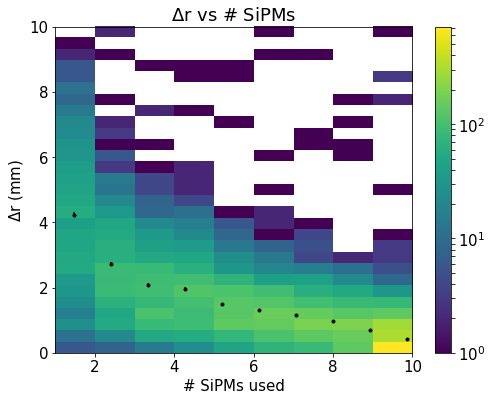

In [59]:
x = np.tile(np.arange(15)+1, sidata.shape[0])
y = sidata.flatten()
plt.hist2d(x, y, [np.arange(1,11),
                  np.linspace(0,10, 30)], norm=LogNorm())
plt.colorbar()

xp, yp, u_yp = fitf.profileX(x, y, 15)
plt.errorbar(xp, yp, u_yp, fmt=".k")
labels("# SiPMs used", "$\Delta$r (mm)", "$\Delta$r vs # SiPMs")